# Nominal Flattop Scenario for CENTAUR #

This notebook creates the nominal input files for CENTAUR. An updated TokaMaker installation is needed to run, which is availible here: https://openfusiontoolkit.github.io/OpenFUSIONToolkit/

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# will output eqdsk files with correct naming if you fill out these files
nb_name = 'CENTAUR_08-2025'

# Basic parameters:

Ip_target = 9.6e6 # A
B0 = 10.917 # Tesla

R0 = 2.0 # m
Z0 = 0.0 # m
a = 0.72
kappa = 1.6
delta = -0.50

xWeight = 50 # targeting weight for x point location
isoWeight = 500 # targeting weight for isoflux shaping points
coilWeight = 3 # coil current minimization weight in coil regularization matrix

In [3]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

In [4]:
############## LOAD TOKAMAKER LIBRARY
sys.path.append('/Applications/OpenFUSIONToolkit/python')
os.environ['OFT_ROOTPATH'] = '/Applications/OpenFUSIONToolkit/python'
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))

from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk, create_power_flux_fun

#  Build mesh
plasma_dx = 0.04
coil_dx = 0.08
vv_dx = 0.05
vac_dx = 0.05

# Define limiter and VV geometry

In [5]:
# limiter and vacuum vessel
inner_LCFS_r = 1.28
outer_LCFS_r = 2.72
LCFS_to_lim = .03
inner_lim_to_VV = .03
outer_lim_to_VV = .05
distance_between_PP_VV = 0.005

bottom_lim = np.array([ [ 1.26      , -0.27      ],
                        [ 1.45      , -0.69      ],
                        [ 2.178 ,  -1.2], # new point
                        [ 2.178       , -1.25-.043      ], # first neck
                        [ 2.3-.017       , -1.56      ],
                        [ 2.46303142, -1.37471264],
                        [ 2.7       , -1.42      ],
                        [ 2.674      , -1.42+.1825       ],   # second divertor neck
                        [ 2.6      ,  -1.1 ], # new point
                        [ 2.73      , -0.45517241]])

# Process the coordinates: reverse order and negate y-values
top_lim = [[x, -y] for x, y in reversed(bottom_lim)]
lim=np.concatenate((bottom_lim,top_lim))
lim_outer=resize_polygon(lim,0.03)

passive_plate_upper = np.array([
    [2.67,0.9],
    [outer_LCFS_r+LCFS_to_lim+outer_lim_to_VV - distance_between_PP_VV,0.86],
    [outer_LCFS_r+LCFS_to_lim+outer_lim_to_VV - distance_between_PP_VV,1.15],
    [2.65,1.1]])
passive_plate_lower = np.array([[x, -y] for x, y in reversed(passive_plate_upper)])


## VV for both ICRF on LFS and LHCD on HFS, and passive plates
vv_top_inner = np.array([   [3.08, 0.5 ],
                            [2.8 , 0.7 ],
                            [2.8 , 1.5 ],
                            [2.45, 1.63],
                            [2.22, 1.63],
                            [2.14, 1.42],
                            [1.4 , 0.86],
                            [1.23, 0.27]])

vv_bottom_inner = [[x, -y] for x, y in reversed(vv_top_inner)]
vv_inner=np.concatenate((vv_top_inner,vv_bottom_inner))

vv_outer = resize_polygon(vv_inner, 0.04)

vv_outer[8,0]+=.01
vv_outer[7,0]+=.01

np.savetxt('DeviceDescription/'+nb_name+'_lim.csv',          lim,        delimiter=',')
np.savetxt('DeviceDescription/'+nb_name+'_lim_outer.csv',    lim_outer,  delimiter=',')
np.savetxt('DeviceDescription/'+nb_name+'_vv_outer.csv',     vv_outer,   delimiter=',')
np.savetxt('DeviceDescription/'+nb_name+'_vv_inner.csv',     vv_inner,   delimiter=',')

# Coil placement

In [6]:
# TF coils
def miller(npts, R0, Z0, a, kappa, delta, zeta): # zeta = squareness
    thetas = np.linspace(0,2*np.pi, npts)
    R = R0 + a*np.cos(thetas + np.arcsin(delta)*np.sin(thetas)-zeta*np.sin(2*thetas))
    Z = Z0 + a*kappa*np.sin(thetas)
    return np.column_stack((R,Z))

magnet_R0 = 2.35 # defined in inputs cell above
magnet_a = 1.27
magnet_kappa = 1.33
magnet_delta = 0
magnet_zeta = 0

tf_inner = miller(100, magnet_R0, 0, magnet_a, magnet_kappa, magnet_delta, magnet_zeta) 
tf_outer = resize_polygon(tf_inner, 0.4)

In [7]:
#### PLACE COILS

PF1U = np.array([[1.15      , 1.87      ],
       [1.15152241, 1.86234633],
       [1.15585786, 1.85585786],
       [1.16234633, 1.85152241],
       [1.17      , 1.85      ],
       [1.43      , 1.85      ],
       [1.43765367, 1.85152241],
       [1.44414214, 1.85585786],
       [1.44847759, 1.86234633],
       [1.45      , 1.87      ],
       [1.45      , 1.98      ],
       [1.45152241, 1.98765367],
       [1.45585786, 1.99414214],
       [1.46234633, 1.99847759],
       [1.47      , 2.        ],
       [1.73      , 2.        ],
       [1.73765367, 2.00152241],
       [1.74414214, 2.00585786],
       [1.74847759, 2.01234633],
       [1.75      , 2.02      ],
       [1.75      , 2.33      ],
       [1.74847759, 2.33765367],
       [1.74414214, 2.34414214],
       [1.73765367, 2.34847759],
       [1.73      , 2.35      ],
       [1.47      , 2.35      ],
       [1.46234633, 2.34847759],
       [1.45585786, 2.34414214],
       [1.45152241, 2.33765367],
       [1.45      , 2.33      ],
       [1.45      , 2.22      ],
       [1.44847759, 2.21234633],
       [1.44414214, 2.20585786],
       [1.43765367, 2.20152241],
       [1.43      , 2.2       ],
       [1.17      , 2.2       ],
       [1.16234633, 2.19847759],
       [1.15585786, 2.19414214],
       [1.15152241, 2.18765367],
       [1.15      , 2.18      ]])

PF1L = [[x, -y] for x, y in reversed(PF1U)]

PF2r = 2.87
PF2z = 2.31
PF2w = 0.6
PF2h = 0.36
PF2rot = 0

PF3r = 4.0
PF3z = 1.33
PF3w = 0.36
PF3h = 0.45
PF3rot = 0

CS_h = 4.2
CS_R_in = 0.51
cs_outer = resize_polygon(miller(500, magnet_R0, 0, magnet_a, magnet_kappa, magnet_delta, magnet_zeta), 0.4)
cs_part = cs_outer[(cs_outer[:,0]<0.75) & (cs_outer[:,1] > 0.01)]
CSU = np.vstack((cs_part, [CS_R_in, 0.01], [CS_R_in, CS_h/2], [0.75, CS_h/2]))
CSL = np.array([[x, -y] for x, y in CSU])

PF2U = np.array([[3.17      , 2.47      ],
       [3.16847759, 2.47765367],
       [3.16414214, 2.48414214],
       [3.15765367, 2.48847759],
       [3.15      , 2.49      ],
       [2.59      , 2.49      ],
       [2.58234633, 2.48847759],
       [2.57585786, 2.48414214],
       [2.57152241, 2.47765367],
       [2.57      , 2.47      ],
       [2.57      , 2.15      ],
       [2.57152241, 2.14234633],
       [2.57585786, 2.13585786],
       [2.58234633, 2.13152241],
       [2.59      , 2.13      ],
       [3.15      , 2.13      ],
       [3.15765367, 2.13152241],
       [3.16414214, 2.13585786],
       [3.16847759, 2.14234633],
       [3.17      , 2.15      ]])

PF2L = [[x, -y] for x, y in reversed(PF2U)]

PF3U = np.array([[4.18      , 1.535     ],
       [4.17847759, 1.54265367],
       [4.17414214, 1.54914214],
       [4.16765367, 1.55347759],
       [4.16      , 1.555     ],
       [3.84      , 1.555     ],
       [3.83234633, 1.55347759],
       [3.82585786, 1.54914214],
       [3.82152241, 1.54265367],
       [3.82      , 1.535     ],
       [3.82      , 1.125     ],
       [3.82152241, 1.11734633],
       [3.82585786, 1.11085786],
       [3.83234633, 1.10652241],
       [3.84      , 1.105     ],
       [4.16      , 1.105     ],
       [4.16765367, 1.10652241],
       [4.17414214, 1.11085786],
       [4.17847759, 1.11734633],
       [4.18      , 1.125     ]])

PF3L = [[x, -y] for x, y in reversed(PF3U)]

coils = {
    'CSU':  {'contour': CSU},
    'PF1U': {'contour': PF1U},
    'PF2U': {'contour': PF2U},
    'PF3U': {'contour': PF3U},
    'CSL':  {'contour': CSL},
    'PF1L': {'contour':PF1L},
    'PF2L': {'contour': PF2L},
    'PF3L': {'contour': PF3L}
}

############## DEFINE REGIONS AND ATTRIBUTES

# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')
gs_mesh.define_region('plasma',plasma_dx,'plasma')
gs_mesh.define_region('passive_plate_upper',vv_dx,'conductor',eta=8e-8) 
gs_mesh.define_region('passive_plate_lower',vv_dx,'conductor',eta=8e-8) 
gs_mesh.define_region('vacuum',vv_dx,'vacuum', allow_xpoints=True)
gs_mesh.define_region('vv',vv_dx,'conductor',eta=7.7e-7)

# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_dx,'coil')

# Define vaccum vessel geometry
gs_mesh.add_polygon(lim,'plasma',parent_name='vacuum')
gs_mesh.add_polygon(passive_plate_upper,'passive_plate_upper',parent_name='vacuum')
gs_mesh.add_polygon(passive_plate_lower,'passive_plate_lower',parent_name='vacuum')
gs_mesh.add_annulus(vv_inner,'vacuum',vv_outer,'vv',parent_name='air') # Define the shape of the VV

# Define the shape of the coils
for key, coil in coils.items():
    if key in ['PF1U', 'PF1L', 'CSU', 'CSL', 'PF3U', 'PF3L', 'PF2U', 'PF2L']:
        gs_mesh.add_polygon(coil['contour'],key,parent_name='air')
    else:
        gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air', rot=coil['rotdeg'])

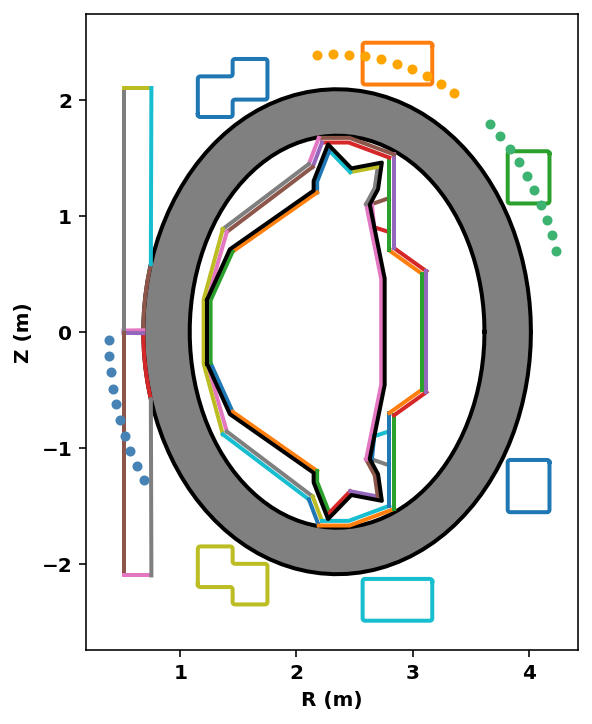

In [8]:
## Plot VV, CS, PFs

fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)

# plot TF coil outline
ax.plot(tf_inner[:,0], tf_inner[:,1], color='black')
ax.plot(tf_outer[:,0], tf_outer[:,1], color='black')
ax.fill(tf_inner[:,0], tf_inner[:,1],tf_outer[:,0], tf_outer[:,1], color = 'gray')
ax.fill(tf_inner[:,0], tf_inner[:,1], color = 'white')
gs_mesh.plot_topology(fig,ax)

# plot outer limiter (just for vizualization)
ax.plot(lim_outer[:,0], lim_outer[:,1], color='black')
ax.plot([lim_outer[-1,0], lim_outer[0,0]], [lim_outer[-1,1],lim_outer[0,1]], color = 'black')

PFmat = resize_polygon(tf_outer, 0.3)

start1 = 5
end1 = 15
start2 = 17
end2 = 27
start3 = 50
end3 = 60

ax.plot(PFmat[start1:end1,0], PFmat[start1:end1,1],'.', color = 'mediumseagreen')
ax.plot(PFmat[start2:end2,0], PFmat[start2:end2,1],'.', color = 'orange')
ax.plot(PFmat[start3:end3,0], PFmat[start3:end3,1],'.', color = 'steelblue')

fig.savefig('DeviceDescription/DeviceOutlines.png')

Assembling regions:
  # of unique points    = 1394
  # of unique segments  = 65
Generating mesh:
  # of points  = 19178
  # of cells   = 37916
  # of regions = 14


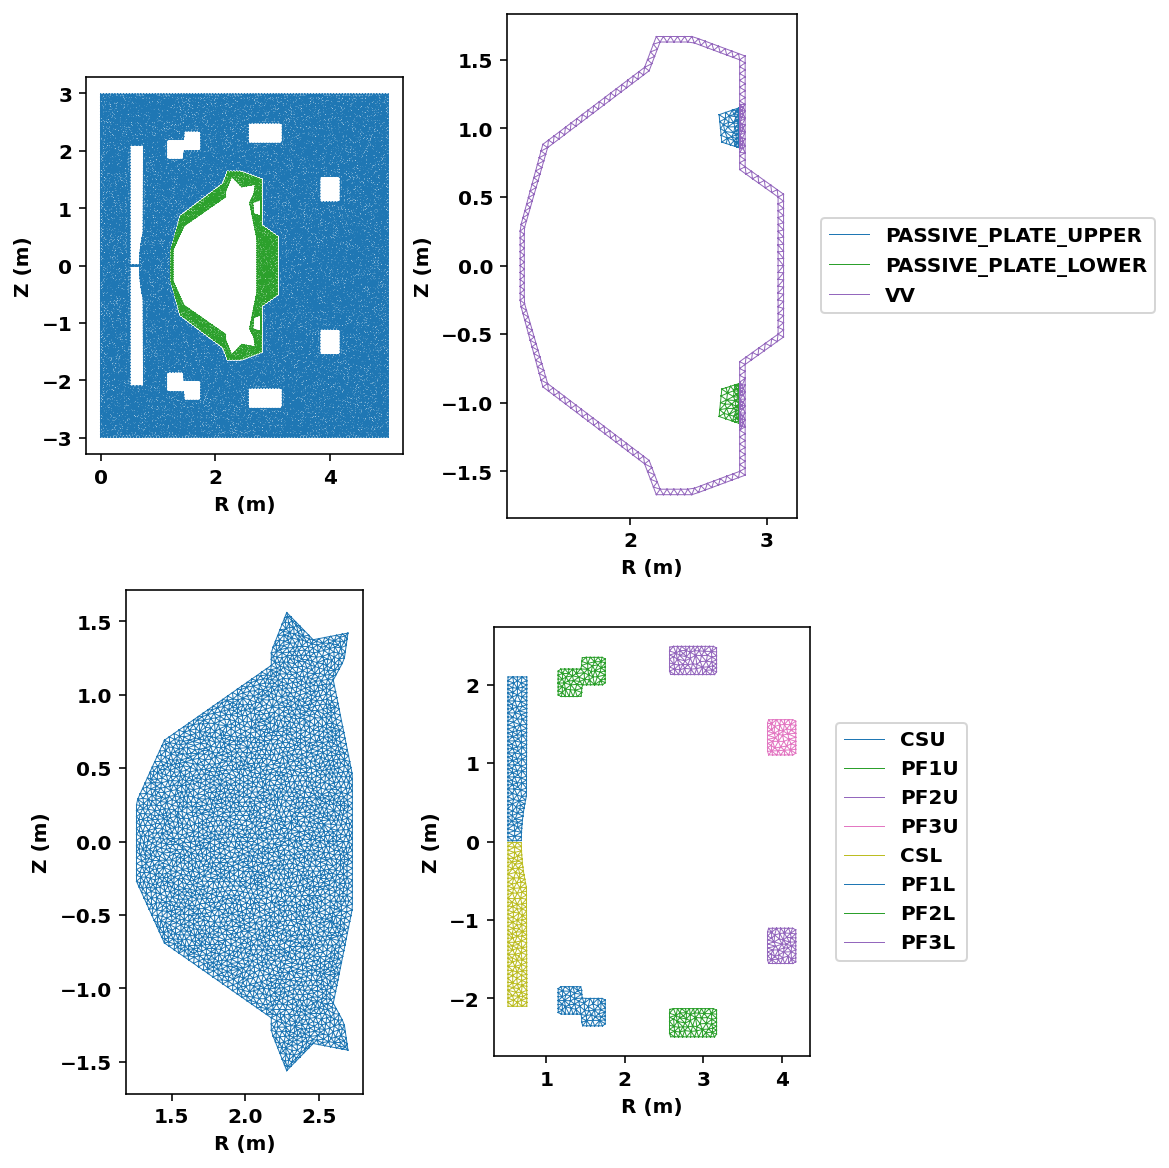

In [9]:
## CREATE MESH

mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()
fig, ax = plt.subplots(2,2,figsize=(8,8),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

fig.savefig('DeviceDescription/CENTAUR-mesh.png')

In [10]:
## SETUP MYFGS

myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=R0*B0)

# DEFINE TARGETS
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          8905cc5
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/05/5bk04kj15rg64s4vd1hd6r0m0000gn/T/oft_67692/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.998E+01
    # of points  =   19178
    # of edges   =   57093
    # of cells   =   37916
    # of boundary points =     438
    # of boundary edges  =     438
    # of boundary cells  =     438
  Resolution statistics:
    hmin =  5.000E-03
    hrms =  4.508E-02
    hmax =  1.178E-01
  Surface grounded at vertex    1335


**** Creating

In [11]:
## DEFINE SHAPE TARGETS

boundary = create_isoflux(4,R0,0.0,a,kappa,delta)

x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_points[1,0] = x_points[0,0]
x_points[1,1] = -x_points[0,1]

x_weights = xWeight*np.ones(2) # moved to inputs area
mygs.set_saddles(x_points, x_weights)

isoflux_weights = isoWeight*np.ones(len(boundary))
mygs.set_isoflux(boundary, isoflux_weights)

In [12]:
## DEFINE COIL REGULARIZATION MATRIX
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = coilWeight*0.5*np.ones(mygs.ncoils+1)

# Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[0,4] = 0
targets[0] = -3E6
targets[4] = -3E6
coil_weights[0] = 5
coil_weights[4] = 5

# Enforce up/down symmetry in PF coils
coil_reg_mat[1,1] = 1
coil_reg_mat[1,5] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,6] = -1
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

## SET UPPER AND LOWER COIL CURRENT LIMITS

coil_bounds = {key: [-1.E11, 1.E11] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

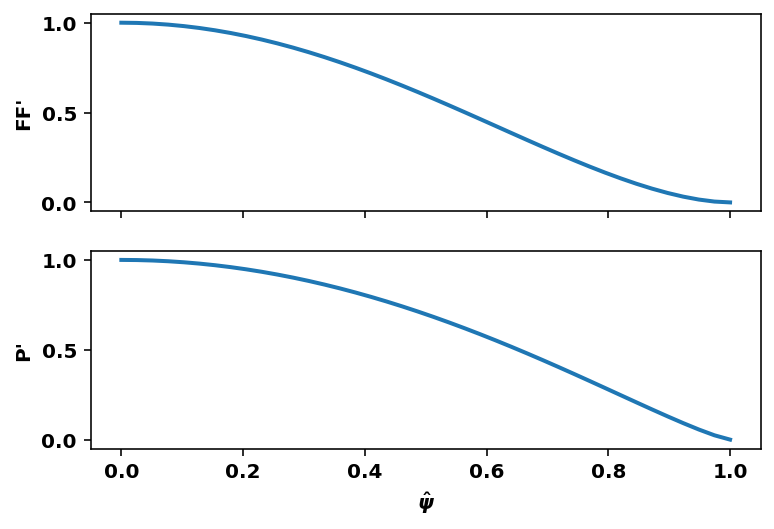

In [13]:
## DEFINE FLUX FUNCTIONS

ffp_prof = create_power_flux_fun(40,2.,1.8) # (num of spline points, alpha, beta)
pp_prof = create_power_flux_fun(40,2,1.25)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [14]:
## COMPUTE EQUILIBRIUM

mygs.init_psi(R0,Z0,a,kappa,delta)
mygs.solve()

Starting non-linear GS solver
     1  1.8760E+01  1.9255E+00  1.9671E-01  2.1229E+00  2.1455E-05 -0.0000E+00
     2  2.1363E+01  2.1760E+00  5.7367E-02  2.1223E+00  3.8352E-05 -0.0000E+00
     3  2.2362E+01  2.2770E+00  1.7784E-02  2.1214E+00  4.9071E-05 -0.0000E+00
     4  2.2774E+01  2.3207E+00  6.9373E-03  2.1205E+00  5.2238E-05 -0.0000E+00
     5  2.2956E+01  2.3411E+00  3.4464E-03  2.1198E+00  5.2984E-05 -0.0000E+00
     6  2.3038E+01  2.3509E+00  1.8922E-03  2.1194E+00  5.2888E-05 -0.0000E+00
     7  2.3076E+01  2.3557E+00  1.0578E-03  2.1191E+00  5.2648E-05 -0.0000E+00
     8  2.3094E+01  2.3580E+00  5.8755E-04  2.1189E+00  5.2467E-05 -0.0000E+00
     9  2.3102E+01  2.3592E+00  3.2264E-04  2.1188E+00  5.2372E-05 -0.0000E+00
    10  2.3106E+01  2.3598E+00  1.7513E-04  2.1188E+00  5.2338E-05 -0.0000E+00
    11  2.3108E+01  2.3600E+00  9.4062E-05  2.1187E+00  5.2330E-05 -0.0000E+00
    12  2.3108E+01  2.3602E+00  5.0048E-05  2.1187E+00  5.2331E-05 -0.0000E+00
    13  2.3109E+01  2.

beta = 2.0305382366583093
beta_n = 1.6625543230707103


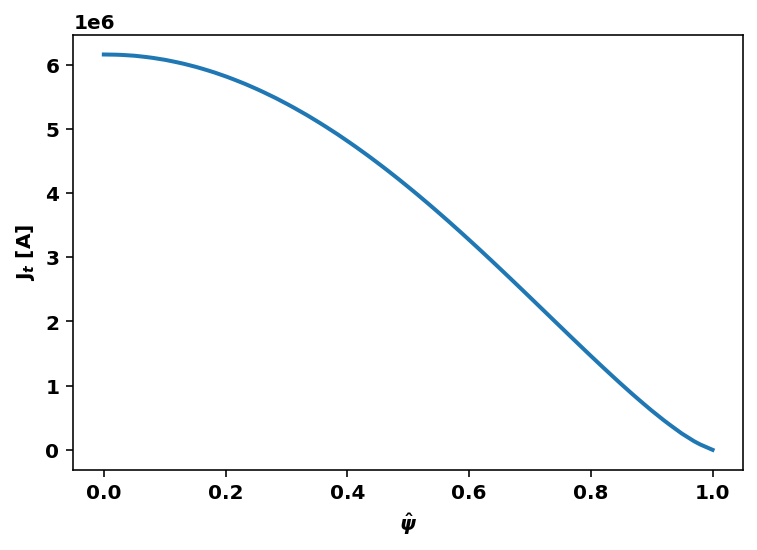

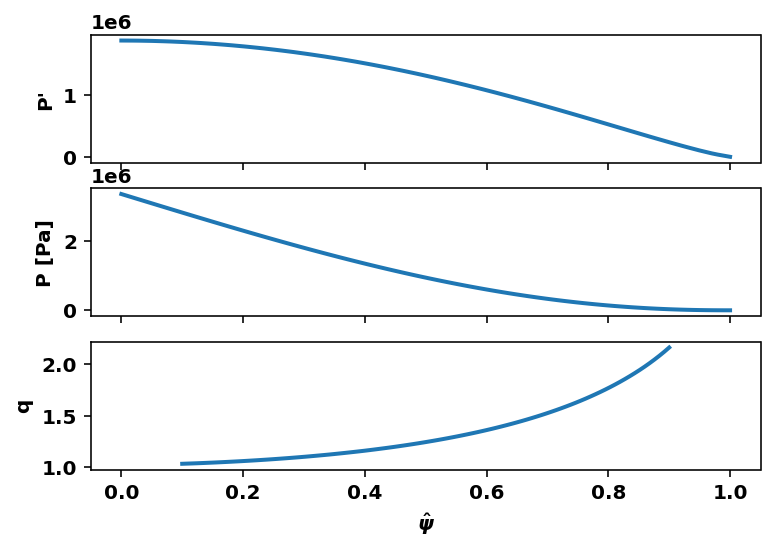

In [15]:
# Check toroidal current profile

def jtor_from_GS(ffprime, pprime, R_avg, one_over_R_avg):
    r'''! Convert from J_toroidal to FF' using Grad-Shafranov equation

    @param jtor Toroidal current profile
    @param R_avg Flux averaged R, calculated by TokaMaker
    @param one_over_R_avg Flux averaged 1/R, calculated by TokaMaker
    @param pprime dP/dPsi profile
    '''
    mu0 = np.pi*4.E-7
    jtor = 0.5*ffprime * (one_over_R_avg / mu0) + R_avg * pprime

    return jtor

psi,f,fp,p,pp = mygs.get_profiles(npsi=100)
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.1,npsi=100)
R_avg = ravgs[0]
one_over_R_avg = ravgs[1]
ffprime = f*fp
jtor = jtor_from_GS(ffprime, pp, R_avg, one_over_R_avg)

fig, ax = plt.subplots(1,1)
# Plot Jtor
ax.plot(psi,jtor)
ax.set_ylabel("J$_t$ [A]")
_ = ax.set_xlabel(r"$\hat{\psi}$")

# Check P, P', q profiles
fig, ax = plt.subplots(3,1,sharex=True)
# Plot P'
ax[0].plot(psi,pp)
ax[0].set_ylabel("P'")
# Plot P
ax[1].plot(psi,p)
ax[1].set_ylabel("P [Pa]")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

# Check global beta, beta_N
Ip,centroid,vol,pvol,dflux,tflux,Bp_vol = mygs.get_globals()


mu0 = 4*np.pi*1e-07
beta = (2.0*pvol*mu0/vol)/(B0**2)
betan = beta*(B0)*a/(Ip/1e+06)
print('beta = '+str(beta*100))
print('beta_n = '+str(betan*100))


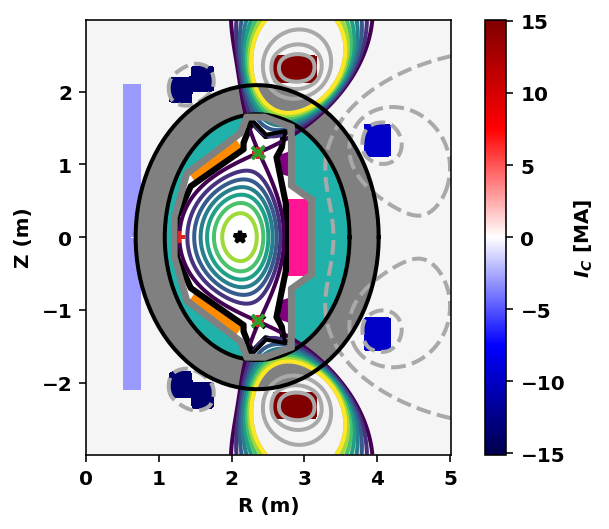

In [16]:
fig, ax = plt.subplots(1,1)

ax.plot(passive_plate_upper[:,0], passive_plate_upper[:,1], color = 'purple')
# ax.plot(passive_plate_upper[:,0], passive_plate_upper[:,1], color = 'purple')
ax.plot([passive_plate_upper[-1,0], passive_plate_upper[0,0]], [passive_plate_upper[-1,1], passive_plate_upper[0,1]], color = 'purple')

ax.plot(passive_plate_lower[:,0], passive_plate_lower[:,1], color = 'purple')
ax.plot([passive_plate_lower[-1,0], passive_plate_lower[0,0]], [passive_plate_lower[-1,1], passive_plate_lower[0,1]], color = 'purple')

mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)


ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')
# ax.set_xlim(0,4.1)

# plot toroidal field coil outlines
ax.plot(tf_inner[:,0], tf_inner[:,1], color='black')
ax.plot(tf_outer[:,0], tf_outer[:,1], color='black')
ax.fill(tf_inner[:,0], tf_inner[:,1],tf_outer[:,0], tf_outer[:,1], color = 'gray')
ax.fill(tf_inner[:,0], tf_inner[:,1], color = 'white')

# plot shielding between VV and TF
ax.fill(vv_outer[:,0], vv_outer[:,1],tf_inner[:,0], tf_inner[:,1], color = 'lightseagreen')
ax.fill(vv_outer[:,0], vv_outer[:,1], color = 'white')

ax.fill(passive_plate_lower[:,0], passive_plate_lower[:,1], color = 'purple')
ax.fill(passive_plate_upper[:,0], passive_plate_upper[:,1], color = 'purple')

# plotting antennae

# ICRF
left = 2.76
right = left + .28
top = .5
bottom = -1*top
ax.fill([ left, right, right, left, left ], [top, top, bottom, bottom, top], color = 'deeppink')
ax.plot([ left, right, right, left, left ], [top, top, bottom, bottom, top], color = 'deeppink')

# LHCD
LHCD_bottom = np.array( [[1.51, -0.793],
                        [2.114, -1.220],
                        [2.051, -1.311],
                        [1.443, -0.884]])


LHCD_color = 'darkorange'
ax.plot(LHCD_bottom[:,0], LHCD_bottom[:,1], color = LHCD_color)
ax.plot([LHCD_bottom[-1,0], LHCD_bottom[0,0]], [LHCD_bottom[-1,1], LHCD_bottom[0,1]], color = LHCD_color)
ax.fill(LHCD_bottom[:,0], LHCD_bottom[:,1], color = LHCD_color)

LHCD_top = np.array([
    [LHCD_bottom[0][0], -1*LHCD_bottom[0][1]],
    [LHCD_bottom[1][0], -1*LHCD_bottom[1][1]],
    [LHCD_bottom[2][0], -1*LHCD_bottom[2][1]],
    [LHCD_bottom[3][0], -1*LHCD_bottom[3][1]]])

ax.plot(LHCD_top[:,0], LHCD_top[:,1], color = LHCD_color)
ax.plot([LHCD_top[-1,0], LHCD_top[0,0]], [LHCD_top[-1,1], LHCD_top[0,1]], color = LHCD_color)
ax.fill(LHCD_top[:,0], LHCD_top[:,1], color = LHCD_color)

# plot outer lim
ax.plot(lim_outer[:,0], lim_outer[:,1], color='black')
ax.plot([lim_outer[-1,0], lim_outer[0,0]], [lim_outer[-1,1],lim_outer[0,1]], color = 'black')

vv_color = 'gray'
ax.plot(vv_inner[:,0], vv_inner[:,1], color = vv_color)
ax.plot(vv_outer[:,0], vv_outer[:,1], color = vv_color)
ax.plot([vv_inner[-1,0], vv_inner[0,0]], [vv_inner[-1,1],vv_inner[0,1]], color = vv_color)
ax.plot([vv_outer[-1,0], vv_outer[0,0]], [vv_outer[-1,1],vv_outer[0,1]], color = vv_color)

fig.savefig(f'EQLibrary/{nb_name}.png')

In [17]:
mygs.print_info()
stats = mygs.get_stats()
print('  beta_n \t\t  =    '+str(np.round(betan*100,4)))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.6000E+06
  Current Centroid [m]    =    2.076  0.000
  Magnetic Axis [m]       =    2.119  0.000
  Elongation              =    1.624 (U:  1.617, L:  1.632)
  Triangularity           =   -0.516 (U: -0.516, L: -0.515)
  Plasma Volume [m^3]     =   29.914
  q_0, q_95               =    1.020  2.491
  Plasma Pressure [Pa]    =   Axis:  3.3353E+06, Peak:  3.3353E+06
  Stored Energy [J]       =    4.3205E+07
  <Beta_pol> [%]          =   57.7671
  <Beta_tor> [%]          =    2.0313
  <Beta_n>   [%]          =    1.6613
  Diamagnetic flux [Wb]   =    2.3559E-01
  Toroidal flux [Wb]      =    2.5720E+01
  l_i                     =    1.0791
  beta_n 		  =    1.6626


In [18]:
## Print coil currents

coil_currents = mygs.get_coil_currents() 

# Shoelace formula for area of PF1
x = PF1U[:, 0]
y = PF1U[:, 1]
PF1area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    if coil_currents[key] >= 0.0:
        proximity = coil_currents[key]*100/coil_bounds[key][1]
        near_limit = coil_bounds[key][1]
    else:
        proximity = coil_currents[key]*100/coil_bounds[key][0]
        near_limit = coil_bounds[key][0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[key]/1.E3,near_limit/1.E3,proximity))

print('\nPF current density limit (VIPER) = \t   73\t\t MA/m^2')
print('PF1U current: \t ', round(coil_currents['PF1U']/1e6,5), ' \tMA \t ', round(coil_currents['PF1U']/(PF1area*1e6),5), '\t MA/m^2')
print('PF1L current: \t ', round(coil_currents['PF1L']/1e6,5), ' \tMA \t ', round(coil_currents['PF1L']/(PF1area*1e6),5), '\t MA/m^2')
print('PF2U current: \t ', round(coil_currents['PF2U']/1e6,5), ' \tMA \t ', round(coil_currents['PF2U']/(PF2w*PF2h*1e6),5), '\t MA/m^2')
print('PF2L current: \t ', round(coil_currents['PF2L']/1e6,5), ' \tMA \t ', round(coil_currents['PF2L']/(PF2w*PF2h*1e6),5), '\t MA/m^2')
print('PF3U current: \t ', round(coil_currents['PF3U']/1e6,5), ' \tMA \t ', round(coil_currents['PF3U']/(PF3w*PF3h*1e6),5), '\t MA/m^2')
print('PF3L current: \t ', round(coil_currents['PF3L']/1e6,5), ' \tMA \t ', round(coil_currents['PF3L']/(PF3w*PF3h*1e6),5), '\t MA/m^2')


Coil Currents [kA]:
  CSU:         -3022.11 (-100000000.00) [  0.00%]
  PF1U:       -13566.29 (-100000000.00) [  0.01%]
  PF2U:        15085.64 (100000000.00) [  0.02%]
  PF3U:        -9878.95 (-100000000.00) [  0.01%]
  CSL:         -3022.18 (-100000000.00) [  0.00%]
  PF1L:       -13566.08 (-100000000.00) [  0.01%]
  PF2L:        15087.09 (100000000.00) [  0.02%]
  PF3L:        -9881.01 (-100000000.00) [  0.01%]

PF current density limit (VIPER) = 	   73		 MA/m^2
PF1U current: 	  -13.56629  	MA 	  -64.71709 	 MA/m^2
PF1L current: 	  -13.56608  	MA 	  -64.71605 	 MA/m^2
PF2U current: 	  15.08564  	MA 	  69.84091 	 MA/m^2
PF2L current: 	  15.08709  	MA 	  69.84762 	 MA/m^2
PF3U current: 	  -9.87895  	MA 	  -60.9812 	 MA/m^2
PF3L current: 	  -9.88101  	MA 	  -60.99387 	 MA/m^2


In [19]:
mygs.save_eqdsk('EQLibrary/'+nb_name + '_truncate_true.geqdsk', truncate_eq = True)
mygs.save_eqdsk('EQLibrary/'+nb_name + '_truncate_false.geqdsk', truncate_eq = False)
mygs.save_eqdsk('EQLibrary/'+nb_name + '_truncate_true_200x200.geqdsk',  truncate_eq = True,   nr=200, nz=200)
mygs.save_eqdsk('EQLibrary/'+nb_name + '_truncate_false_200x200.geqdsk', truncate_eq = False, nr=200, nz=200)

Saving gEQDSK: EQLibrary/CENTAUR_08-2025_truncate_true.geqdsk
Saving gEQDSK: EQLibrary/CENTAUR_08-2025_truncate_false.geqdsk
Saving gEQDSK: EQLibrary/CENTAUR_08-2025_truncate_true_200x200.geqdsk
Saving gEQDSK: EQLibrary/CENTAUR_08-2025_truncate_false_200x200.geqdsk
